In [4]:
"""This notebook was adapted from the following tutorial:
https://keras.io/examples/timeseries/timeseries_classification_from_scratch/
"""

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import StratifiedKFold, train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import f1_score
from imblearn.keras import BalancedBatchGenerator
from imblearn.under_sampling import NearMiss
from tqdm import tqdm
from tf_explain.core.grad_cam import GradCAM


In [5]:
df = pd.read_csv("cleanedTemporalData.csv").set_index('PatientID')

X = []
y = []

for id, group in tqdm(df.groupby('PatientID')):
    tempGroup = group.reset_index()
    
    tempGroup = tempGroup.drop(['PatientID', 'Mortality14Days'], axis=1)

    tempGroup = tempGroup.fillna(0)

    X.append(tempGroup.T.values)
    y.append(group['Mortality14Days'].values[0])


X = np.array(X)
y = np.array(y)


x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(x_train.shape, y_train.shape)

100%|██████████| 959/959 [00:01<00:00, 904.79it/s]

(767, 12, 48) (767,)


In [7]:
pd.Series(y_train).value_counts()

0    736
1     31
dtype: int64

In [8]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=16, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(2, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [9]:
epochs = 10
batch_size = 128

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

weights = pd.Series(y).value_counts().values

classWeights = {x : 1/weights[x] for x in np.unique(y)}

print(classWeights)

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
    class_weight = classWeights,
)

{0: 0.0010822510822510823, 1: 0.02857142857142857}
Epoch 1/10
5/5 [==============================] - 2s 100ms/step - loss: 0.0015 - sparse_categorical_accuracy: 0.3817 - val_loss: 0.7788 - val_sparse_categorical_accuracy: 0.3636 - lr: 0.0010
Epoch 2/10
5/5 [==============================] - 0s 20ms/step - loss: 0.0013 - sparse_categorical_accuracy: 0.5122 - val_loss: 0.7921 - val_sparse_categorical_accuracy: 0.3182 - lr: 0.0010
Epoch 3/10
5/5 [==============================] - 0s 37ms/step - loss: 0.0012 - sparse_categorical_accuracy: 0.6297 - val_loss: 0.7271 - val_sparse_categorical_accuracy: 0.4610 - lr: 0.0010
Epoch 4/10
5/5 [==============================] - 0s 36ms/step - loss: 0.0011 - sparse_categorical_accuracy: 0.6933 - val_loss: 0.6523 - val_sparse_categorical_accuracy: 0.6494 - lr: 0.0010
Epoch 5/10
5/5 [==============================] - 0s 36ms/step - loss: 0.0010 - sparse_categorical_accuracy: 0.7488 - val_loss: 0.6258 - val_sparse_categorical_accuracy: 0.7078 - lr: 0.001

In [10]:
history.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'lr'])

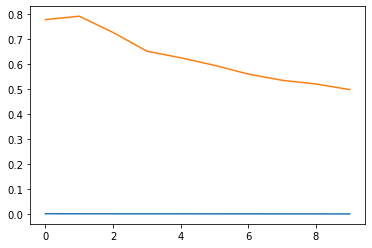

In [11]:
plt.plot(range(len(history.history['loss'])), history.history['loss'])
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'])
plt.show()

In [12]:
preds = np.argmax(model.predict(x_test), axis=1)
display(f1_score(y_test, preds, average="macro"))

6/6 [==============================] - 0s 1ms/step


0.5178302360622802

In [14]:
x_test[0]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.77000000e+02, 1.66962963e+02, 1.58629630e+02,
        1.52000000e+02, 1.47074074e+02, 1.43851852e+02, 1.42333333e+02,
        1.42518519e+02, 1.44407407e+02, 1.48000000e+02, 1.53296296e+02,
        1.60296296e+02, 1.69000000e+02, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000

In [15]:
explainer = GradCAM()
grid = explainer.explain(([x_test[0]], None), model, class_index=0)

ValueError: Model does not seem to contain 4D layer. Grad CAM cannot be applied.